In [2]:
%load_ext autoreload
%autoreload 2

import mdtraj as mdt
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append("../../analysis")
from relax import build_corrs_dict, fit_lmfit


In [3]:
def build_avg_corr_dict(basedir):
    basedir = Path(basedir)

    xtcs = list(basedir.glob("*a_132/md_nojump.xtc"))
    pdbs = [xtc.with_suffix(".pdb") for xtc in xtcs]

    corrs_dicts = []

    t = None

    for pdb, xtc in zip(pdbs, xtcs):
        traj = mdt.load(xtc, top=pdb)
        corrs_dict, t_ = build_corrs_dict(traj)
        corrs_dicts.append(corrs_dict)

        if t is None:
            t = t_
        else:
            assert np.all(t == t_)

    tot = {}
    for corr_dict in corrs_dicts:
        for key, corr in corr_dict.items():
            tot.setdefault(key, []).append(corr)

    avg_corr_dict = {
        key: (np.mean(corrs, axis=0), np.std(corrs, axis=0))
        for key, corrs in tot.items()
    }

    return avg_corr_dict, t


ref_avg_corr_dict, t_ref = build_avg_corr_dict(
    "/home/gzappavigna/traj/20241018_ff99sb-ildn_opc_multidir"
)
cmap_avg_corr_dict, t_cmap = build_avg_corr_dict(
    "/home/gzappavigna/traj/20241025_ff99sb-ildn_opc_cmap_multidir"
)

In [4]:

with open("ref_avg_corr.pkl", "wb") as f:
    pickle.dump([ref_avg_corr_dict, t_ref], f)

with open("cmap_avg_corr.pkl", "wb") as f:
    pickle.dump([cmap_avg_corr_dict, t_cmap], f)


In [20]:
with open("ref_avg_corr.pkl", "rb") as f:
    ref_avg_corr_dict, t_ref = pickle.load(f)

with open("cmap_avg_corr.pkl", "rb") as f:
    cmap_avg_corr_dict, t_cmap = pickle.load(f)


In [4]:
# ref_xtc = "/home/gzappavigna/traj/20241007_ff99sb-ildn-opc/md_nojump.xtc"
# ref_pdb = "/home/gzappavigna/traj/20241007_ff99sb-ildn-opc/md_nojump.pdb"

# ref_traj = mdt.load(ref_xtc, top=ref_pdb, stride=2)
# ref_avg_corr_dict, t_ref = build_corrs_dict(ref_traj)
# del ref_traj

# cmap_xtc = "/home/gzappavigna/traj/20241015_ff99sb-ildn-opc_cmap/md_nojump.xtc"
# cmap_pdb = "/home/gzappavigna/traj/20241015_ff99sb-ildn-opc_cmap/md_nojump.pdb"

# cmap_traj = mdt.load(cmap_xtc, top=cmap_pdb, stride=2)
# cmap_avg_corr_dict, t_cmap = build_corrs_dict(cmap_traj)
# del cmap_traj

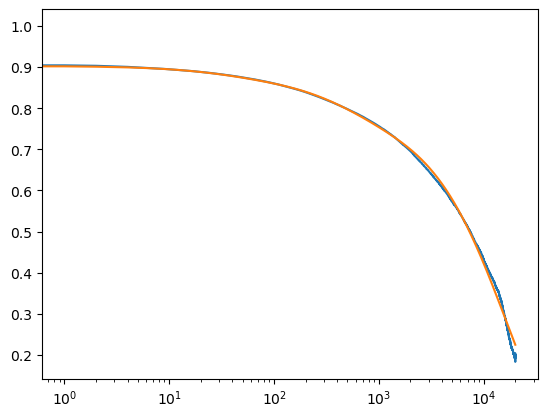

In [31]:
corr = ref_avg_corr_dict[129]
t = t_ref
# corr = cmap_corr_dict[121]
# t = t_cmap

tau0s = np.array([10.0, 100.0, 1000.0, 10000.0])

# A0s = 2.0 ** np.arange(tau0s.size)
A0s = np.ones_like(tau0s)
A0s /= A0s.sum()

As, taus, res = fit_lmfit(t[1:corr.size], corr[1:], A0s, tau0s)

plt.semilogx(corr)
plt.semilogx(res.eval())

In [8]:
def fit_avg_corrs(avg_corr_dict, t):
    fit_params = {}
    # tau0s = np.array([10.0, 100.0, 1000.0])
    # tau0s = np.array([10.0, 100.0, 1000.0, 5000.0, 10000.0])
    tau0s = np.array([1e1, 1e2, 1e3, 1e4])

    A0s = np.ones_like(tau0s)
    # A0s = 2.0 ** np.arange(tau0s.size)
    A0s /= A0s.sum()

    for key, (corr, err) in avg_corr_dict.items():
        print(key)
        # As, A0, lambdas = fit_r(t[:corr.size], corr, [-1e-3, -1e-2])
        # As, lambdas = fit(t[1:corr.size], corr[1:], np.ones_like(corr[1:]), A0s, lambda0s)
        As, taus, _ = fit_lmfit(t[1:], corr[1:], err[1:], A0s, tau0s)

        fit_params[key] = (As, taus)
        # A0s, tau0s = As, taus

    resids = np.array(list(fit_params.keys()))
    As = np.array([As for As, _ in fit_params.values()])
    taus = np.array([taus for _, taus in fit_params.values()])

    idx = np.argsort(-taus, axis=1)
    As = np.take_along_axis(As, idx, axis=1)
    taus = np.take_along_axis(taus, idx, axis=1)

    return resids, As, taus



In [ ]:
ref_resids, ref_As, ref_taus = fit_avg_corrs(ref_avg_corr_dict, t_ref)
cmap_resids, cmap_As, cmap_taus = fit_avg_corrs(cmap_avg_corr_dict, t_cmap)

ref_resids += 401 - 8
cmap_resids += 401 - 8

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
64
65
66
67
68
69
70
71
72
73
74
76
77
78
80
81
82
83
84
85
86
87
88
89
90
91
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
123
124
125
126
127
128
129
130
131
132
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
64
65
66
67
68
69
70
71
72
73
74
76
77
78
80
81
82
83
84
85
86
87
88
89
90
91
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
123
124
125
126
127
128
129
130
131
132


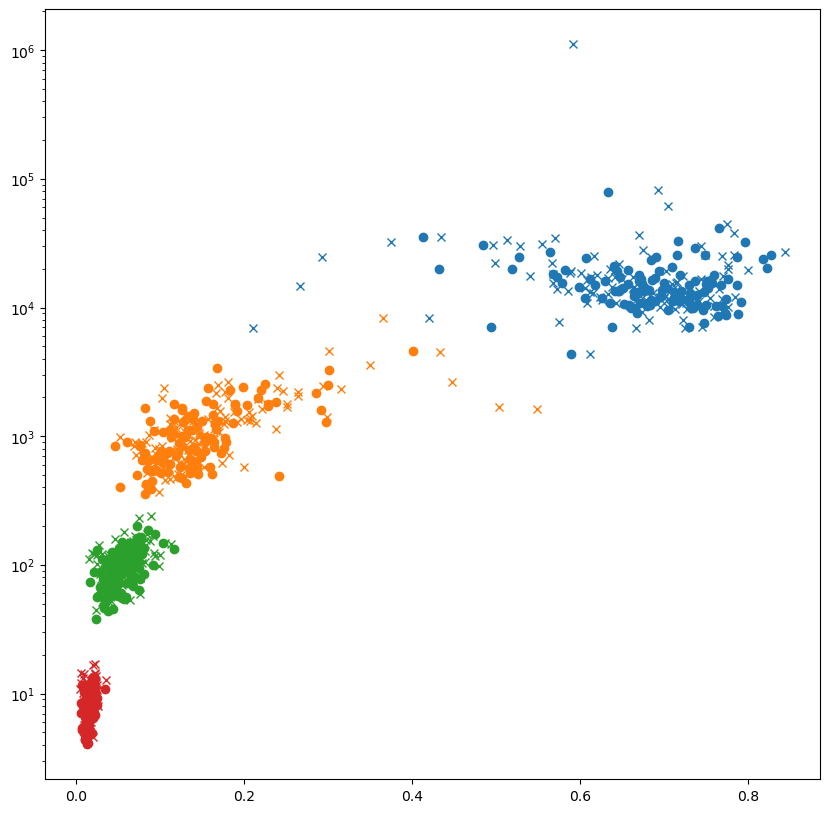

In [10]:
plt.yscale("log")
fig = plt.gcf()
fig.set_figwidth(10)
fig.set_figheight(10)
plt.yscale("log")


mask = (ref_taus.max(axis=1) < 1e7) & (cmap_taus.max(axis=1) < 1e7)
# mask = (ref_taus.max(axis=1) < 1e100) & (cmap_taus.max(axis=1) < 1e100)


for i in range(ref_As.shape[1]):
    plt.plot(ref_As[mask, i], ref_taus[mask, i], 'o')

plt.gca().set_prop_cycle(None)

for i in range(cmap_As.shape[1]):
    plt.plot(cmap_As[mask, i], cmap_taus[mask, i], "x")


In [49]:
# r1_df = pd.read_csv("exp_data/850MHz-25C/R1.out", sep=" ", header=None, index_col=0)
r1_df = pd.read_csv("exp_data/600MHz-25C/R1.out", sep=" ", header=None, index_col=0)
# r2_df = pd.read_csv("exp_data/850MHz-25C/R2.out", sep=" ", header=None, index_col=0)
r2_df = pd.read_csv("exp_data/600MHz-25C/R2.out", sep=" ", header=None, index_col=0)

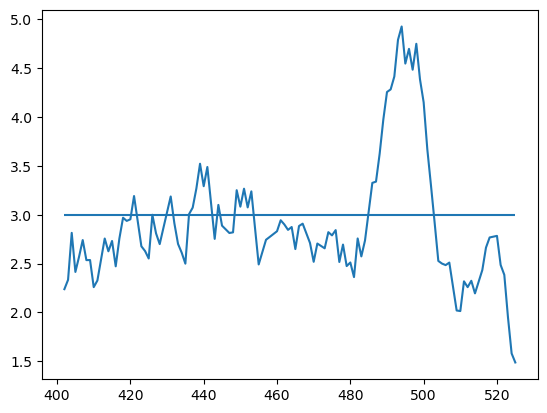

In [34]:
plt.plot(r2_df[1])
plt.hlines(3, 402, 525)


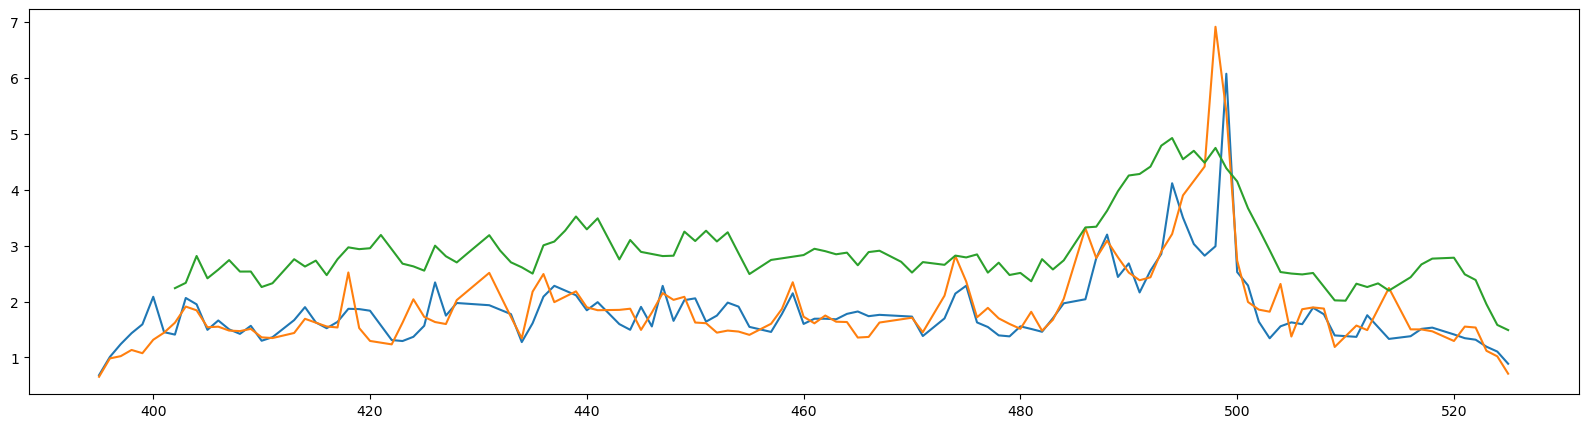

In [142]:
from nmr_relax_rates import NMR_relaxation_rates


plt.figure(figsize=(20, 5))

rates = NMR_relaxation_rates(ref_As, ref_taus, 600)
# plt.plot(ref_resids[mask & (rates.R2 < 10)], rates.R2[mask & (rates.R2 < 10)])
plt.plot(ref_resids[mask], rates.R2[mask])


rates = NMR_relaxation_rates(cmap_As, cmap_taus, 600)
plt.plot(cmap_resids[mask & (rates.R2 < 30)], rates.R2[mask & (rates.R2 < 30)])

# plt.plot(cmap_resids[mask], rates.R2[mask])

# plt.hlines(3, 400, 525)

plt.plot(r2_df[1])

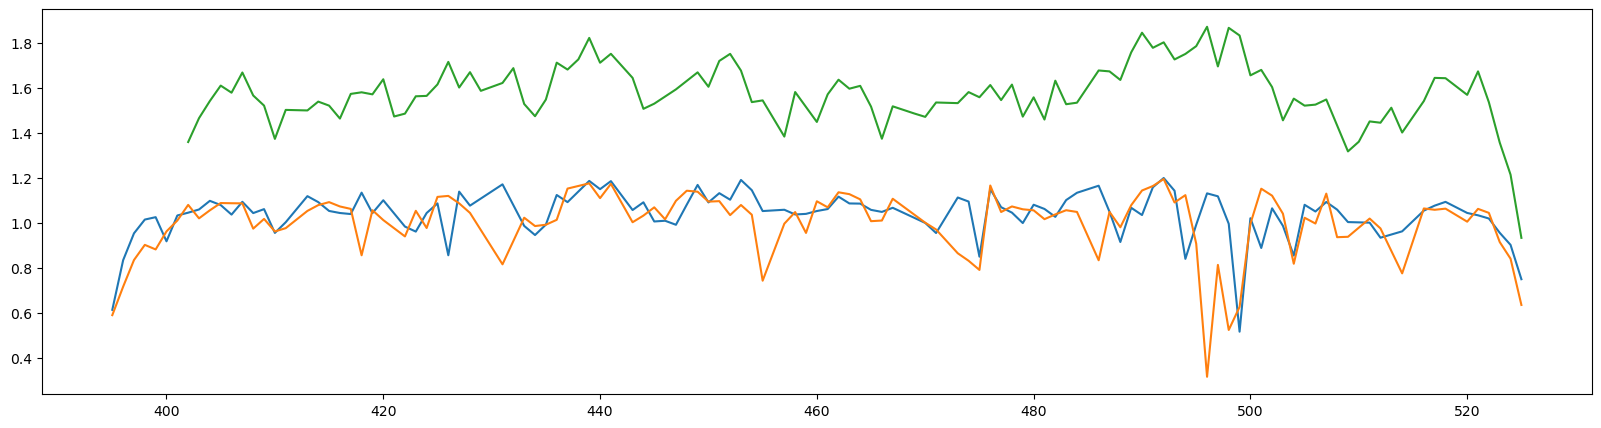

In [141]:
plt.figure(figsize=(20, 5))

rates = NMR_relaxation_rates(ref_As, ref_taus, 600)
plt.plot(ref_resids[mask], rates.R1[mask])


rates = NMR_relaxation_rates(cmap_As, cmap_taus, 600)
plt.plot(cmap_resids[mask], rates.R1[mask])

plt.plot(r1_df[1])


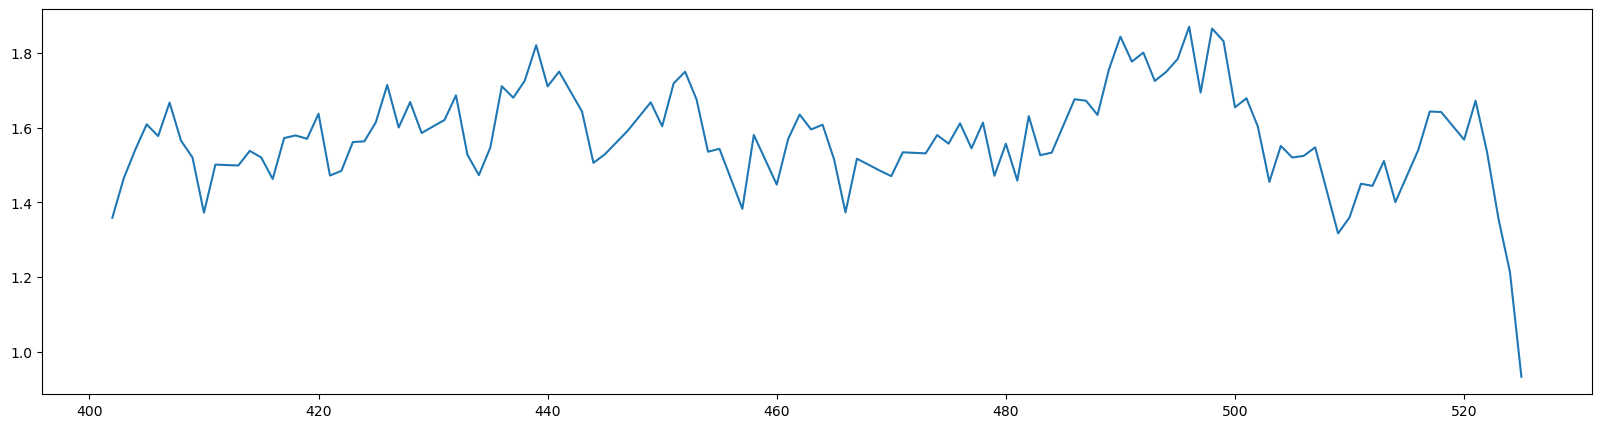

In [111]:
plt.figure(figsize=(20, 5))
plt.plot(r1_df[1])


In [138]:
cmap_resids + 401 - 8

array([395, 396, 397, ..., 523, 524, 525])

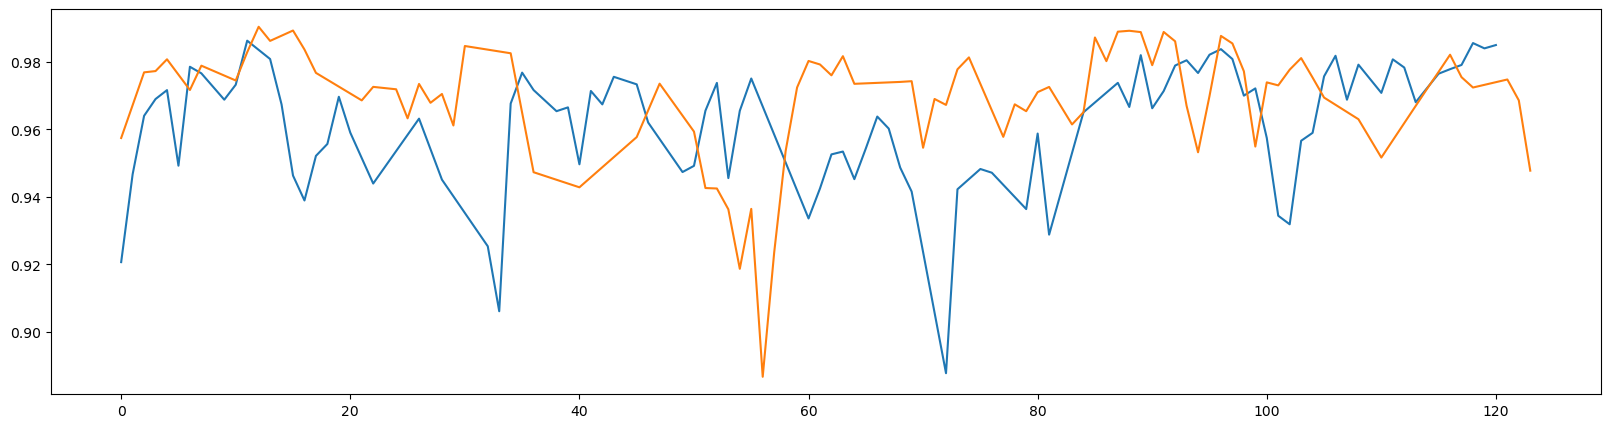

In [19]:
plt.figure(figsize=(20, 5))

rates = NMR_relaxation_rates(ref_As, ref_taus, 800)
resids = np.arange(rates.R1.size)
mask = ref_taus.max(axis=1) < 1e7
plt.plot(resids[mask], rates.NOE[mask])


rates = NMR_relaxation_rates(cmap_As, cmap_taus, 800)
resids = np.arange(rates.R1.size)
mask = cmap_taus.max(axis=1) < 1e7
plt.plot(resids[mask], rates.NOE[mask])